# Quantitative Metric for LLM perturbation-based Attribution

Our attribution library supports different perturbation and attribution strategies. To provide more context, we'll start by going through the basic outline of a perturbation attribution method:

1. Pass in the desired input and generate an output using it from the LLM we want to study
2. Perturb input tokens by replacing them with 'another' token and capture the new generated output
3. Compare the original output and the perturbed output to 'calculate' the change in the output
4. We assign a high attribution to the input tokens for which the calculated change in output is high and vice versa

The process of selecting another token to perturb input tokens is called a 'perturbation strategy' and the process of calculating the change in output is called an 'attribution strategy'.

We provide support for 2 perturbation strategies:

1. Fixed: This replaces the input token with a fixed token which is selected to be the `' '` token
2. NthNearest: This replaces the input token with another token that is n spaces away from it after sorting all other tokens in the vocabulary by distance to the input token being replaced. Here n is a hyperparameter and can range from 0 to vocabulary size.

We also provide support for 3 attribution strategies:

1. Cosine: This calculates the cosine similarity between embeddings of the original output and the perturbed output
2. Prob_diff: This calculates the difference in logprobs of the perturbed output and original output tokens
3. Token displacement: This calculates the number of positions the original output token was displaced in the list of logprobs for that token position

## Importing Libraries

In [2]:
import os
import sys
import timeit
import warnings
from time import time
from typing import List

import openai
from dotenv import load_dotenv
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
)

notebook_path = os.path.abspath(get_ipython().starting_dir)
parent_path = os.path.dirname(notebook_path)

sys.path.append(parent_path)
warnings.simplefilter("ignore")

In [3]:
from attribution.api_attribution import APILLMAttributor
from attribution.experiment_logger import ExperimentLogger
from attribution.attribution_metrics import (
    cosine_similarity_attribution,
    token_displacement,
    token_prob_difference,
)
from attribution.token_perturbation import FixedPerturbationStrategy, NthNearestPerturbationStrategy

## Example Usage of Attribution library

We start off by showing an example of our attribution library to get attribution scores for input tokens corresponding to their importance in generating output tokens. 

We use the string, "Maria is 37 years old today. How many years till she\'s 50?"" in this example. This is actually a carefully crafted input and it's significance will be explained in the next section.

In [5]:
attributor = APILLMAttributor()
logger = ExperimentLogger()
attributor.compute_attributions(
    "Maria is 37 years old today. How many years till she's 50?",
    perturbation_strategy=FixedPerturbationStrategy(),
    attribution_strategies=["cosine"],
    logger=logger,
    perturb_word_wise=False,
)
display(logger.df_experiments)
logger.print_sentence_attribution()
logger.print_attribution_matrix(exp_id=1)

,exp_id,original_input,original_output,perturbation_strategy,perturb_word_wise,duration
0,1,Maria is 37 years old today. How many years ti...,Maria is 13 years away from turning 50.,fixed,False,13.700149


,exp_id,attribution_strategy,perturbation_strategy,perturb_word_wise,token_1,token_2,token_3,token_4,token_5,token_6,token_7,token_8,token_9,token_10,token_11,token_12,token_13,token_14,token_15
0,1,cosine,fixed,False,Maria 0.15,is 0.07,37 0.09,years 0.00,old 0.07,today 0.00,. 0.00,How 0.07,many 0.00,years 0.07,till 0.08,she 0.00,'s 0.00,50 0.19,? 0.00


Attribution matrix for experiment 1 
Attribution Strategy: cosine 
Perturbation strategy: fixed:
Input Tokens (Rows) vs. Output Tokens (Columns)


,Maria (0),is (1),(2),13 (3),years (4),away (5),from (6),turning (7),(8)
Maria (0),0.780266,0.716820,0.701984,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
is (1),0.000000,0.000000,0.765618,0.702294,0.733874,0.709888,0.785968,0.702294,0.900795
37 (2),0.000000,0.000000,0.505145,0.753443,0.761518,0.713754,0.769884,0.764375,0.140691
years (3),0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000
old (4),0.000000,0.000000,0.765618,0.702294,0.733874,0.709888,0.785968,0.702294,0.900795
today (5),0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000
. (6),0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000
How (7),0.000000,0.171263,0.000000,0.000000,0.681663,0.644735,0.424010,0.000000,0.000000
many (8),0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000
years (9),0.000000,0.171263,0.000000,0.000000,0.681663,0.644735,0.424010,0.000000,0.000000


## Reasonable Ground Truth

Let's start off by explaining the significance of our chosen input string shown above. The question "Maria is 37 years old today. How many years till she\'s 50?" is special because the answer to this questions can only be obtained by directly observing the input (or atleast that's our hypothesis). This makes it so that we can make an assertion on which input tokens *should* strongly attribute to which output tokens. For the above question, the answer is "13 years". 

There *should* be high attribution between:
1. Input tokens - 37 (from "37 years") and 50
2. Output tokens - 13 (from "13 years") 

On observing the attribution matrix above, we can see that these attribution values are reasonably high pointing to the fact that our chosen perturbation and attribution strategies work quite well for this example. Let's quantify this signal and move on to more robustly benchmarking these strategies!

## Metric calculation

Using the logic from above we can assign *relevant* input and output ids for which to calculate success. Success here is whether or not these relevant input and output ids correspond to high attribution. We define high attribution as higher than the mean attribution for all input tokens for any given output token. This definition is not quite principled but it is yet again a *reasonable* choice.

In [6]:
relevant_input_ids = [2, 13]
relevant_output_ids = [3]

perturbation_strategy = 'fixed'
exp_id = 1
attribution_strategy = 'cosine'

for output_id in relevant_output_ids:
    success = 0
    total = 0
    mean_attr_score = logger.df_token_attribution_matrix[(logger.df_token_attribution_matrix['exp_id'] == exp_id) & (logger.df_token_attribution_matrix['attribution_strategy'] == attribution_strategy) & (logger.df_token_attribution_matrix['output_token_pos'] == output_id)]['attr_score'].mean()
    for input_id in relevant_input_ids:
        attr_score = logger.df_token_attribution_matrix[(logger.df_token_attribution_matrix['exp_id'] == exp_id) & (logger.df_token_attribution_matrix['attribution_strategy'] == attribution_strategy) & (logger.df_token_attribution_matrix['output_token_pos'] == output_id) & (logger.df_token_attribution_matrix['input_token_pos'] == input_id)]['attr_score'].item()
        if attr_score > mean_attr_score:
            success += 1
        total += 1

print(f'Metric score for perturbation_strategy: {perturbation_strategy} and attribution_strategy: {attribution_strategy} - {success/total}')

Metric score for perturbation_strategy: fixed and attribution_strategy: cosine - 1.0


## Scaling up!

We extend the previous analysis by expanding to 10 crafted questions that share similar characteristics to the one shown above. We also increase the hyperparameters we're assessing:

1. Perturbation strategies: NthNearest - 1,10,100,1000,10000,-1(most distant) and Fixed
2. Attribution strategies: cosine, prob_diff and token_displacement

__NOTE__: We also print out the logging table for each input string to ensure that the output strings are what we expect and our predefined output ids are valid.

In [12]:
input_strings = ['The clock shows 9:47 PM. How many minutes to 10PM?', 
                 'Maria is 37 years old today. How many years till she\'s 50?', 
                 'John has 83 books on his shelf. If he buys 17 more books, how many books will he have in total?', 
                 'The building is 132 meters tall. How many centimeters tall is the building? No explanation', 
                 'The package weighs 8.6 kilograms. How many grams does the package weigh?', 
                 'Jack has 12 teaspoons of sugar. How many tablespoons of sugar does he have?',
                'Alex saved $363 from his birthday gifts. If he spends $45 on a new game, how much money will he have left? No explanation.',
                'The building is 132 meters tall. How many centimeters tall is the building? No explanation.',
                'The thermometer reads 23 degrees Celsius. What is the temperature in Fahrenheit? No explanation.',
                'There are 12 eggs in a dozen. If you use 5 eggs, how many eggs are left?'
                ]

relevant_input_ids = [[3,5,12], 
                      [2, 13], 
                      [2, 11], 
                      [3], 
                      [2], 
                      [2], 
                      [3, 13], 
                      [3], 
                      [4], 
                      [2, 11]]

relevant_output_ids = [[0], 
                       [3], 
                       [11], 
                       [0, 2], 
                       [16, 26], 
                       [26], 
                       [1], 
                       [0, 2], 
                       [0, 2], 
                       [4]]

scores = {}
for i, string in enumerate(input_strings):
    print(f'Calculating attributions for {string}')
    logger = ExperimentLogger()
    attributor = APILLMAttributor()
    for n in [1, 10, 100, 1000, 10000, -1]:
        attributor.compute_attributions(
            string,
            perturbation_strategy=NthNearestPerturbationStrategy(n),
            attribution_strategies=["cosine", "prob_diff", "token_displacement"],
            logger=logger,
            perturb_word_wise=True,
        )

    attributor.compute_attributions(
            string,
            perturbation_strategy=FixedPerturbationStrategy(),
            attribution_strategies=["cosine", "prob_diff", "token_displacement"],
            logger=logger,
            perturb_word_wise=True,
        )
    
    input_ids = relevant_input_ids[i]
    output_ids = relevant_output_ids[i]

    perturbation_strategy = ['nth_nearest (n=1)', 'nth_nearest (n=10)', 'nth_nearest (n=100)', 'nth_nearest (n=1000)', 'nth_nearest (n=10000)', 'nth_nearest (n=-1)', 'fixed']
    for exp_id in range(1,8):
        for attribution_strategy in ['cosine', 'prob_diff', 'token_displacement']:
            for output_id in output_ids:
                success = 0
                total = 0
                mean_attr_score = logger.df_token_attribution_matrix[(logger.df_token_attribution_matrix['exp_id'] == exp_id) & (logger.df_token_attribution_matrix['attribution_strategy'] == attribution_strategy) & (logger.df_token_attribution_matrix['output_token_pos'] == output_id)]['attr_score'].mean()
                for input_id in input_ids:
                    attr_score = logger.df_token_attribution_matrix[(logger.df_token_attribution_matrix['exp_id'] == exp_id) & (logger.df_token_attribution_matrix['attribution_strategy'] == attribution_strategy) & (logger.df_token_attribution_matrix['output_token_pos'] == output_id) & (logger.df_token_attribution_matrix['input_token_pos'] == input_id)]['attr_score'].item()
                    if attr_score > mean_attr_score:
                        success += 1
                    total += 1

            if f'{perturbation_strategy[exp_id-1]}-{attribution_strategy}' in scores:
                scores[f'{perturbation_strategy[exp_id-1]}-{attribution_strategy}'] += success/total
            else:
                scores[f'{perturbation_strategy[exp_id-1]}-{attribution_strategy}'] = 0
                scores[f'{perturbation_strategy[exp_id-1]}-{attribution_strategy}'] += success/total

    display(logger.df_experiments)
        #print(f'Metric score for perturbation_strategy: {perturbation_strategy[exp_id-1]} and attribution_strategy: {attribution_strategy} - {success/total}')

Calculating attributions for The clock shows 9:47 PM. How many minutes to 10PM?


,exp_id,original_input,original_output,perturbation_strategy,perturb_word_wise,duration
0,1,The clock shows 9:47 PM. How many minutes to 1...,13 minutes.,nth_nearest (n=1),True,10.868052
1,2,The clock shows 9:47 PM. How many minutes to 1...,13 minutes.,nth_nearest (n=10),True,11.816831
2,3,The clock shows 9:47 PM. How many minutes to 1...,13 minutes.,nth_nearest (n=100),True,9.456161
3,4,The clock shows 9:47 PM. How many minutes to 1...,13 minutes.,nth_nearest (n=1000),True,9.422876
4,5,The clock shows 9:47 PM. How many minutes to 1...,13 minutes.,nth_nearest (n=10000),True,11.189732
5,6,The clock shows 9:47 PM. How many minutes to 1...,13 minutes.,nth_nearest (n=-1),True,9.663846
6,7,The clock shows 9:47 PM. How many minutes to 1...,13 minutes.,fixed,True,6.273052


Calculating attributions for Maria is 37 years old today. How many years till she's 50?


,exp_id,original_input,original_output,perturbation_strategy,perturb_word_wise,duration
0,1,Maria is 37 years old today. How many years ti...,Maria is 13 years away from turning 50.,nth_nearest (n=1),True,16.631733
1,2,Maria is 37 years old today. How many years ti...,Maria is 13 years away from turning 50.,nth_nearest (n=10),True,16.449703
2,3,Maria is 37 years old today. How many years ti...,Maria is 13 years away from turning 50.,nth_nearest (n=100),True,16.649855
3,4,Maria is 37 years old today. How many years ti...,Maria is 13 years away from turning 50.,nth_nearest (n=1000),True,17.570224
4,5,Maria is 37 years old today. How many years ti...,Maria is 13 years away from turning 50.,nth_nearest (n=10000),True,16.423392
5,6,Maria is 37 years old today. How many years ti...,Maria is 13 years away from turning 50.,nth_nearest (n=-1),True,21.355495
6,7,Maria is 37 years old today. How many years ti...,Maria is 13 years away from turning 50.,fixed,True,11.786731


Calculating attributions for John has 83 books on his shelf. If he buys 17 more books, how many books will he have in total?


,exp_id,original_input,original_output,perturbation_strategy,perturb_word_wise,duration
0,1,John has 83 books on his shelf. If he buys 17 ...,John will have 100 books in total. \n\n83 + 17...,nth_nearest (n=1),True,27.329785
1,2,John has 83 books on his shelf. If he buys 17 ...,John will have 100 books in total. \n\n83 + 17...,nth_nearest (n=10),True,24.266962
2,3,John has 83 books on his shelf. If he buys 17 ...,John will have 100 books in total. \n\n83 + 17...,nth_nearest (n=100),True,27.711994
3,4,John has 83 books on his shelf. If he buys 17 ...,John will have 100 books in total. \n\n83 + 17...,nth_nearest (n=1000),True,24.469076
4,5,John has 83 books on his shelf. If he buys 17 ...,John will have 100 books in total. \n\n83 + 17...,nth_nearest (n=10000),True,25.466384
5,6,John has 83 books on his shelf. If he buys 17 ...,John will have 100 books in total. \n\n83 + 17...,nth_nearest (n=-1),True,26.159523
6,7,John has 83 books on his shelf. If he buys 17 ...,John will have 100 books in total. (83 + 17 = ...,fixed,True,20.124802


Calculating attributions for The building is 132 meters tall. How many centimeters tall is the building? No explanation


,exp_id,original_input,original_output,perturbation_strategy,perturb_word_wise,duration
0,1,The building is 132 meters tall. How many cent...,"13,200 centimeters",nth_nearest (n=1),True,11.239617
1,2,The building is 132 meters tall. How many cent...,"13,200 centimeters",nth_nearest (n=10),True,13.35759
2,3,The building is 132 meters tall. How many cent...,"13,200 centimeters",nth_nearest (n=100),True,13.938824
3,4,The building is 132 meters tall. How many cent...,"13,200 centimeters",nth_nearest (n=1000),True,13.586667
4,5,The building is 132 meters tall. How many cent...,"13,200 centimeters",nth_nearest (n=10000),True,13.587075
5,6,The building is 132 meters tall. How many cent...,"13,200 centimeters",nth_nearest (n=-1),True,14.370199
6,7,The building is 132 meters tall. How many cent...,"13,200 centimeters",fixed,True,10.324049


Calculating attributions for The package weighs 8.6 kilograms. How many grams does the package weigh?


## Plotting results

In [23]:
import pandas as pd

score_df = {'perturbation_strategy': ['-'.join(key.split('-')[0:-1]) for key in scores.keys()], 'attribution_strategy': [key.split('-')[-1] for key in scores.keys()], 'success': list(scores.values())}
score_df = pd.DataFrame(data=score_df, index=[i for i in range(len(scores))])

In [24]:
score_df

,perturbation_strategy,attribution_strategy,success
0,nth_nearest (n=1),cosine,7.500000
1,nth_nearest (n=1),prob_diff,8.500000
2,nth_nearest (n=1),token_displacement,8.666667
3,nth_nearest (n=10),cosine,6.000000
4,nth_nearest (n=10),prob_diff,7.500000
5,nth_nearest (n=10),token_displacement,6.666667
6,nth_nearest (n=100),cosine,7.166667
7,nth_nearest (n=100),prob_diff,8.666667
8,nth_nearest (n=100),token_displacement,8.166667
9,nth_nearest (n=1000),cosine,7.500000


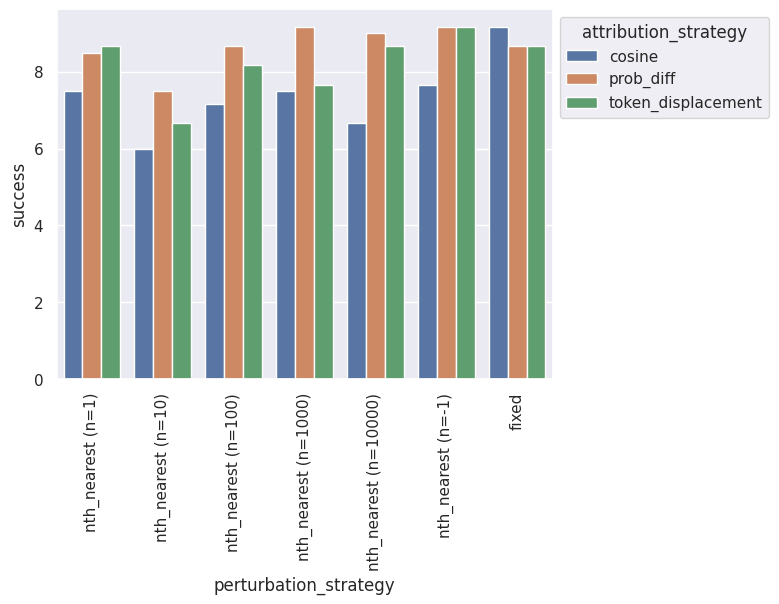

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

g = sns.barplot(data=score_df, x='perturbation_strategy', y='success', hue='attribution_strategy')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

## Conclusion

The maximum success rate i.e. 9.167/10 was achieved by:

- `nth_nearest(n=1000)` perturbation and `prob_diff` attribution
- `nth_nearest(n=-1)` perturbation and `prob_diff` attribution
- `nth_nearest(n=-1)` perturbation and `token_displacement` attribution
- `fixed` perturbation and `cosine` attribution

There is no clear indication that a single combination of perturbation and attribution strategies is the best. We encourage users to further experiment with these perturbation and attribution strategies along with innovative methods of calculating quantitative metrics to verify our attribution method.

Based on our initial experiment and qualitative analysis, we would recommend using the `fixed` perturbation strategy and the `cosine` attribution strategy for it's relative stability (in the cases we tested) and overall correctness.